<a href="https://colab.research.google.com/gist/nirshlezinger1/3e92bc16d28c8f2f7feb5031e32b5618/discriminative-and-generative-learning-for-linear-estimation-of-random-signals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Discriminative vs. Generative Learning for Linear Estimation of Random Signals

In this notebook we exemplify the comparison between generative and discriminative learning for linear estimation of random signals.  The scenario considered is that of estimating a random signal from a set of jointly Guassian random measurements.

In [1]:
from scipy.linalg import toeplitz, dft
import numpy as np
import matplotlib.pyplot as plt
inv = np.linalg.inv

np.random.seed(12)

## Data Generation
The task at hand deals with the recovery of the target signal  $\textbf{y}$ from the observed measurements  $\textbf{x}$. 

In the considered setting, one has prior knowledge that the target $\textbf{y}$ obeys the following Gaussian distribution 
\begin{equation}
\textbf{s}\sim\mathcal{N}(\mu_{\textbf{s}},\textbf{C}_{\textbf{s}\textbf{s}}),
\end{equation}
and that the measurements follow a linear model given by
\begin{equation} \textbf{x} = \textbf{H}\textbf{s} + \textbf{w}, \quad \textbf{w}\sim\mathcal{N}({\mu},\sigma^2\textbf{I}). 
\end{equation}


Given the above statstical model, the following function generates a batch of $n_t$ samples

In [2]:
# Data generation 
def create_data(sqrt_R_y, prior_mu_y, sigma_w,n, m, P, H):
    # create the P samples {x_t, y_t}
    y = np.matmul(sqrt_R_y, np.random.randn(m,P)) + prior_mu_y.reshape(m,1)
    w = np.multiply(sigma_w,np.random.randn(n,P))
    x = np.matmul(H, y) + w
    return x, y

## Estimators
We consider the task of estimating $\textbf{y}$ from $\textbf{x}$, where the quality of an estimate is easured in the mean-squared error (MSE) sense, i.e.,
\begin{equation}
{\rm MSE}(\hat{\textbf{y}}) := \mathbb{E}\{\|{\textbf{y}}-\hat{\textbf{y}}\|^2\}.
\end{equation} 
The update of the MSE is implemented via the following function

In [3]:
def calculate_mse(sum_before, true, estimator, num_iterations):
    return sum_before + np.sum(np.square(true - estimator))/num_iterations

We focus on the scenario where the statistical moments $\mu_s,\textbf{C}_{\textbf{s}\textbf{s}}, \sigma$ are known, while  $\textbf{H},\mu$ are unknown, thus we are considering a setup with partial domain knowledge. 
For such settings, we numerically compare three different estimators:


1.   The minimal MSE (MMSE) estimate, which has full knowledge of the underlying statistics and serves as a lower bound on the achievable MSE.
2.   The discrimative learning estimator, which uses labeled data to directly learn an estimator while exploiting the available domain knowledge to impose a linear form.
3.   The generative learning estimator, which uses data to estimate the missing statistics, and uses them to compute the MMSE estimate. 

The data-aided estimator rely on the computations of the sample means  
$$\bar{\textbf{x}}\equiv \frac{1}{n_t}\sum_{i=1}^{n_t} \textbf{x}^i,~~~\bar{\textbf{s}}\equiv \frac{1}{n_t}\sum_{i=1}^{n_t} \textbf{s}_t$$
and the sample covariance/cross-covariance matrices 
$$\hat{\textbf{C}}_{ \textbf{s}\textbf{x}} = \frac{1}{n_t} \sum_{i=1}^{n_t} ( \textbf{s}^i - \bar{ \textbf{s}})(\textbf{x}^i -\bar{\textbf{x}})^T,$$


$$\hat{\textbf{C}}_{ \textbf{s} \textbf{s}} =\frac{1}{n_t} \sum_{i=1}^{n_t} ( \textbf{s}^i - \bar{ \textbf{s}})( \textbf{s}^i - \bar{ \textbf{s}})^T,$$

$$	 \hat{\textbf{C}}_{\textbf{x}\textbf{x}} = \frac{1}{n_t} \sum_{i=1}^{n_t} (\textbf{x}^i - \bar{\textbf{x}})(\textbf{x}^i - \bar{\textbf{x}})^T.$$ 



### MMSE Estimator
The MMSE estimator is given by

$$\hat{\textbf{s}}_{\text{mmse}}=
{\textbf{C}}_{\textbf{s}\textbf{x}} {\textbf{C}}_{\textbf{x}\textbf{x}}^{-1}(\textbf{x}-\mu_{\textbf{x}})+\mu_{\textbf{s}}.$$

Now, by noting that $\mu_{\textbf{x}}={\textbf{H}\mu_{\textbf{s}}}$, 
$\textbf{C}_{\textbf{s}\textbf{x}}=\textbf{C}_{\textbf{s}\textbf{s}}{\textbf{H}}^T$, and 
$\textbf{C}_{\textbf{x}\textbf{x}}={\textbf{H}}\textbf{C}_{\textbf{s}\textbf{s}}{\textbf{H}}^T+\sigma^2\textbf{I}$, the expression can be written as

$$\hat{\textbf{s}}_{\text{mmse}}=
\textbf{C}_{\textbf{s}\textbf{s}}{\textbf{H}}^T ({\textbf{H}}\textbf{C}_{\textbf{s}\textbf{s}}{\textbf{H}}^T+\sigma^2\textbf{I})^{-1}(\textbf{x}-{\textbf{H}\mu_{\textbf{s}}})+\mu_{\textbf{s}}.$$

In [4]:
def calc_mmse_estimator(x_realization, prior_mu_y, H, prior_C_yy, sigma_w):
    prior_C_yx = np.matmul(prior_C_yy, np.transpose(H))
    prior_C_xx =  np.matmul(H, prior_C_yx) + np.multiply(np.square(sigma_w),np.identity(H.shape[0]))
    prior_mu_x =  np.matmul(H,prior_mu_y)
    return prior_mu_y + np.matmul(prior_C_yx, np.matmul(inv(prior_C_xx), (x_realization - prior_mu_x)))

### Discrimative Learning Estimator
The discriminative learned estimator is given by 

$$\hat{\textbf{s}}_d= f_{{\theta}^*}(\textbf{x})=
 \hat{\textbf{C}}_{\textbf{s}\textbf{x}} \hat{\textbf{C}}_{\textbf{x}\textbf{x}}^{-1}(\textbf{x}-\bar{\textbf{x}})+\bar{\textbf{s}}.$$

In [5]:
def calc_discriminative_learning_estimator(x_realization, post_mu_y, C_yx, C_xx, post_mu_x):
    return post_mu_y + np.matmul(C_yx, np.matmul(inv(C_xx), (x_realization - post_mu_x)))

### Generative Learning Estimator
The generative learning estimator is given by 

$$\hat{\textbf{s}}_g= {{\mu}}_{{\textbf{s}}} +(\hat{\textbf{C}}_{\textbf{s}\textbf{s}}^{-1}\hat{\textbf{C}}_{\textbf{s}\textbf{x}} \hat{\textbf{C}}_{\textbf{x}\textbf{s}}\hat{\textbf{C}}_{\textbf{y}\textbf{s}}^{-1}+ \sigma^2{\textbf{C}}_{\textbf{s} \textbf{s}}^{-1})^{-1}\hat{\textbf{C}}_{\textbf{s}\textbf{s}}^{-1}\hat{\textbf{C}}_{\textbf{s}\textbf{x}} ( \textbf{x} -\bar{\textbf{x}}-\hat{\textbf{C}}_{\textbf{x}\textbf{s}} \hat{\textbf{C}}_{\textbf{s}\textbf{s}}^{-1}({{\mu}}_{\textbf{s}}-\bar{\textbf{s}})).$$


In [6]:
def calc_generative_learning_estimator(x_realization, C_yy,C_yx,C_xy,post_mu_x, post_mu_y, prior_mu_y,prior_C_yy,sigma_w):
    return prior_mu_y + np.matmul(inv(np.matmul(inv(C_yy), np.matmul(C_yx, np.matmul(C_xy, inv(C_yy))))+np.multiply(np.square(sigma_w),inv(prior_C_yy))),
                         np.matmul(inv(C_yy), np.matmul(C_yx, (x_realization - post_mu_x-np.matmul(np.matmul(C_xy, inv(C_yy)),(prior_mu_y - post_mu_y)))))) 

## Main Simualtion
We first define a function which conducts a single experiment of comparing the aforementioned three estimators for a given setting of the system parameters

In [7]:
# Aid function for computing the emprical convariances
def division(a, b, c, d, P):
    return np.divide(np.matmul((a - b), np.transpose(c - d)), P)

# A single experiment function
def expirement(prior_C_yy,prior_mu_y,sigma_w, n_y, P, n_x, H, num_iterations, 
               error_prior_C_yy):

    U, S, Vh = np.linalg.svd(prior_C_yy, full_matrices=True)
    S = np.diag(S)
    sqrt_R_y = np.matmul(np.matmul(U, np.sqrt(S)), Vh)

    # create the P samples {x_t, y_t}
    x, y = create_data(sqrt_R_y, prior_mu_y, sigma_w, n_x, n_y, P, H)

    # estimate the covariance matrices and means
    post_mu_y = np.transpose(np.mean(np.transpose(y), axis=0)).reshape((n_y, 1))
    post_mu_x = np.transpose(np.mean(np.transpose(x), axis=0)).reshape((n_x, 1))
    C_xx = division(x, post_mu_x, x, post_mu_x, P)
    C_yy = division(y, post_mu_y, y, post_mu_y, P)
    C_xy = division(x, post_mu_x, y, post_mu_y, P)
    C_yx = division(y, post_mu_y, x, post_mu_x, P)

    mse_dis = 0
    mse_gen = 0
    mse_mmse = 0
    for j in range(num_iterations):
        x_realization, y_realization = create_data(sqrt_R_y, prior_mu_y, sigma_w,n_x, n_y, 1, H)

        # estimate y
        # discriminative learning
        y_d = calc_discriminative_learning_estimator(x_realization, post_mu_y, C_yx, C_xx, post_mu_x)
        # generative learning
        y_g = calc_generative_learning_estimator(
            x_realization, C_yy, C_yx, C_xy, post_mu_x, post_mu_y, prior_mu_y, prior_C_yy+error_prior_C_yy, sigma_w)
        # MMSE
        y_mmse = calc_mmse_estimator(x_realization, prior_mu_y, H, prior_C_yy, sigma_w)
        # calculate the MSE
        mse_dis = calculate_mse(mse_dis, y_realization, y_d, num_iterations)
        mse_gen = calculate_mse(mse_gen, y_realization, y_g, num_iterations)
        mse_mmse = calculate_mse(mse_mmse, y_realization, y_mmse, num_iterations)
    mse_dis_sum = np.sum(mse_dis)
    mse_gen_sum = np.sum(mse_gen)
    mmse_sum = np.sum(mse_mmse)
    return mse_dis_sum, mse_gen_sum, mmse_sum


### Simulation Setup
We next determine the main parameters of the system model

In [8]:
n_x = 30 # number of measurements
n_y = 30 # number of target entries

# Resolutions for scanning SNR axis and number of samples axis
resolution_snr = 10
min_power_sigma = -2
max_power_sigma = 0
sigma_array = np.logspace(min_power_sigma, max_power_sigma, resolution_snr)
# default setting
sigma_w = 0.3


resolution_nt = 10
min_nt = 1.1*np.log10(max(n_x,n_y))
max_nt = 2*min_nt
nt_array = np.round(np.logspace(min_nt, max_nt, resolution_nt))
# default setting
nt = 100

num_iterations = 10000



The matrix $\textbf{H}$ is randomized once

In [9]:
# Randomize matrix H
H = np.random.randn(n_x,n_y)

The statistics of the target $\textbf{y}$ are generated by setting the mean to be zero and the covariance to represent spatial decay

In [10]:
r = np.array(list(np.exp(range(0,-n_y,-1))))
prior_C_yy = toeplitz(0.2*r)
prior_mu_y = np.zeros(n_y).reshape(n_y,1)

### Simulation Loop
We compare the estimators above for two settings:


1.   No mismatch - here the system has accurate knowledge of the statsitics of the target $\textbf{y}$.
2.   Misspecified model - here the system has an errornous estimate of the statistics of the target $\textbf{y}$.

The simulation includes a loop over the range of SNR values and over the range of number of sampels, to identify the asymptotics reported in the lecture notes and to numerically provide an evaluation in the non-asymptotic regimes.


We begin with the absence of mismatch

In [11]:
# No mismatch
error_prior_C_yy = np.zeros([n_y,n_y]) 

# MSE vs SNR
mse_dis_snr = np.zeros(resolution_snr)
mse_gen_snr = np.zeros(resolution_snr)
mse_mmse_snr = np.zeros(resolution_snr)
for j in range(resolution_snr):
    current_sigma_w = sigma_array[j]
    mse_dis_snr[j], mse_gen_snr[j], mse_mmse_snr[j] = expirement(prior_C_yy, prior_mu_y,current_sigma_w, n_y, nt, n_x, H, num_iterations, error_prior_C_yy)


# MSE vs number of points
mse_dis_set_size = np.zeros(resolution_nt)
mse_gen_set_size = np.zeros(resolution_nt)
mse_mmse_set_size = np.zeros(resolution_nt)
for j in range(resolution_nt):
    current_nt = int(nt_array[j])
    mse_dis_set_size[j], mse_gen_set_size[j],mse_mmse_set_size[j] = expirement(prior_C_yy,prior_mu_y,  sigma_w, n_y, current_nt, n_x, H, num_iterations, error_prior_C_yy)

And proceed with the presence of mismatch

In [12]:
# With mismatch 
error_prior_C_yy = np.eye(n_y) - prior_C_yy 

# MSE vs SNR
mse_dis_snr_mis = np.zeros(resolution_snr)
mse_gen_snr_mis = np.zeros(resolution_snr)
mse_mmse_snr_mis = np.zeros(resolution_snr)
for j in range(resolution_snr):
    current_sigma_w = sigma_array[j]
    mse_dis_snr_mis[j], mse_gen_snr_mis[j], mse_mmse_snr_mis[j] = expirement(prior_C_yy, prior_mu_y,current_sigma_w, n_y, nt, n_x, H, num_iterations, error_prior_C_yy)


# MSE vs number of points
mse_dis_set_size_mis = np.zeros(resolution_nt)
mse_gen_set_size_mis = np.zeros(resolution_nt)
mse_mmse_set_size_mis = np.zeros(resolution_nt)
for j in range(resolution_nt):
    current_nt = int(nt_array[j])
    mse_dis_set_size_mis[j], mse_gen_set_size_mis[j],mse_mmse_set_size_mis[j] = expirement(prior_C_yy,prior_mu_y,  sigma_w, n_y, current_nt, n_x, H, num_iterations, error_prior_C_yy)

Displaying the results

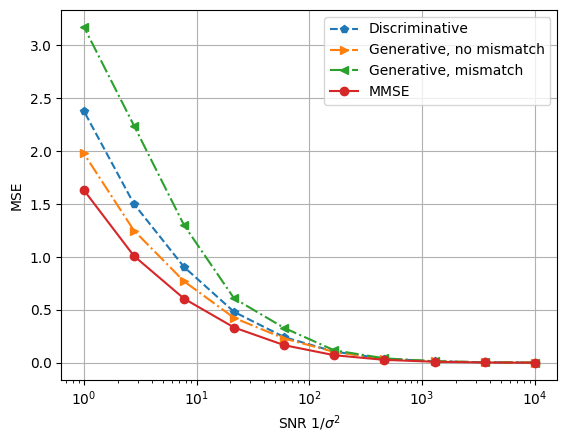

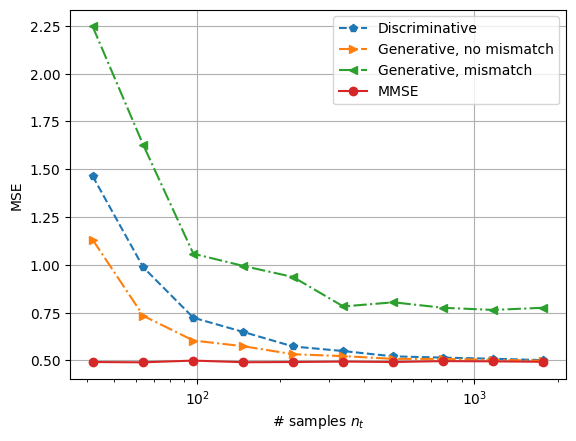

In [13]:
# Plot 1: MSE versus SNR
plt.figure()
plt.semilogx(np.divide(1, np.square(sigma_array)), mse_dis_snr, "--p", 
             np.divide(1, np.square(sigma_array)), mse_gen_snr, "-.>", 
             np.divide(1, np.square(sigma_array)), mse_gen_snr_mis, "-.<",
             np.divide(1, np.square(sigma_array)), mse_mmse_snr,"-o")
plt.legend(['Discriminative', 'Generative, no mismatch', 'Generative, mismatch','MMSE']) 
plt.xlabel('SNR $1/\sigma^2$')
plt.ylabel('MSE')
plt.grid()

# Plot 2: MSE versus number of samples
plt.figure()
plt.semilogx(nt_array, mse_dis_set_size, "--p", 
             nt_array, mse_gen_set_size,"-.>", 
             nt_array, mse_gen_set_size_mis,"-.<",
             nt_array, mse_mmse_set_size,"-o")
plt.legend(['Discriminative', 'Generative, no mismatch', 'Generative, mismatch','MMSE']) 
plt.xlabel('# samples $n_t$')
plt.ylabel('MSE')
plt.grid()
plt.show()